<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_3_2_Integration_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split

class CellDataset(Dataset):
    def __init__(self, numpy_matrix, labels = None):
        self.X = torch.from_numpy(numpy_matrix)
        self.n_genes = self.X.shape[1]
        # Library sizes for each cell, mean and variance across cells
        self.cell_library_sizes = torch.sum(self.X, dim = 1)
        self.labels = labels
        if labels is not None:
            assert self.labels.shape[0] == self.X.shape[0]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.labels is not None:
            return {'x': self.X[idx], 'l': self.cell_library_sizes[idx], 's': self.labels[idx]}
        else:
            return {'x': self.X[idx], 'l': self.cell_library_sizes[idx]}

class BasicAutoencoderIntegration(nn.Module):
    def __init__(self, n_genes, h_dim1, h_dim2,  z_dim, batch_id_max, dropout_rate):
        super(BasicAutoencoderIntegration, self).__init__()
        print(n_genes)
        self.encode1 = nn.Linear(n_genes + batch_id_max + 1, h_dim1)
        self.encode2 = nn.Linear(h_dim1, h_dim2)
        self.encode3 = nn.Linear(h_dim2, z_dim)
        self.decode1 = nn.Linear(z_dim + batch_id_max + 1, h_dim2)
        self.decode2 = nn.Linear(h_dim2, h_dim1)
        self.decode3 = nn.Linear(h_dim1, n_genes)

        self.dropout = nn.Dropout(p=dropout_rate)
    
    def encode(self, x, batch_numbers):
        x = torch.cat([x, batch_numbers], dim=1)
        x = self.dropout(x)
        x = F.relu(self.encode1(x))
        x = self.dropout(x)
        x = F.relu(self.encode2(x))
        x = self.dropout(x)
        x = self.encode3(x)
        return x
    
    def decode(self, x, batch_numbers):
        x = torch.cat([x, batch_numbers], dim=1)
        x = self.dropout(x)
        x = F.relu(self.decode1(x))
        x = self.dropout(x)
        x = F.relu(self.decode2(x))
        x = self.dropout(x)
        x = self.decode3(x)
        return x
    
    def forward(self, x, batch_numbers):
        encodings = self.encode(x, batch_numbers)
        decodings = self.decode(encodings, batch_numbers)
        return decodings

In [16]:
# one hot encoding for batch number
def one_hot(n, max):
    result = torch.zeros(max)
    result[n] = 1.0
    return result

# one hot encodings for list of batch_numbers
def make_sns_onehot(sns, sn_max):
    one_hots = []
    for el in sns:
        sn = int(el.item())
        one_hots.append(one_hot(sn, sn_max+1))
    return torch.stack(one_hots)

def train(model, dataloader, optimizer, loss_function, batch_number_max):
    model.train()
    running_loss = 0.0
    print('Dataset length', len(dataloader.dataset))
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        
        net_input = data['x']
        batch_numbers_onehot = make_sns_onehot(data['s'], batch_number_max)
        net_output = model(net_input.float(), batch_numbers_onehot)
        loss = loss_function(net_input, net_output)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    training_loss = running_loss / len(dataloader.dataset)
    return training_loss

def validate(model, dataloader, optimizer, loss_function, batch_number_max):
    model.eval()
    with torch.no_grad():
        print('Dataset length', len(dataloader.dataset))
        running_loss = 0.0
        for i, data in enumerate(dataloader):

            net_input = data['x']
            batch_numbers_onehot = make_sns_onehot(data['s'], batch_number_max)
            net_output = model(net_input.float(), batch_numbers_onehot)
            loss = loss_function(net_input, net_output)

            running_loss += loss.item()
        validation_loss = running_loss / len(dataloader.dataset)
        return validation_loss

# Load data sets

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
GAUSS_SIM = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_difficult1.npy')
GAUSS_SIM_LABELS = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels2_difficult1.npy')
GAUSS_SIM_BATCH_NUMBER = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels_difficult1.npy')
batch_number_max = int(np.max(GAUSS_SIM_BATCH_NUMBER))

In [9]:
dataset = CellDataset(GAUSS_SIM, GAUSS_SIM_BATCH_NUMBER)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [8000, 1000, 1000])

In [10]:
minibatch_size = 32
train_loader = DataLoader(train_set, batch_size=minibatch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=minibatch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=minibatch_size, shuffle=True)

In [17]:
representation_dimension = 2
net = BasicAutoencoderIntegration(n_genes = dataset.n_genes, 
                                  h_dim1 = 200, 
                                  h_dim2 = 100,
                                  z_dim = representation_dimension,
                                  batch_id_max = batch_number_max,
                                  dropout_rate=0.7)
loss_function = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(net.parameters())

epoch = 0
best_val_loss = 10e10
stopEpochs = False

history_epochs = []
history_train = []
history_val = []
for epoch_i in range(5):
    epoch += 1
    print('Epoch', epoch)
    train_loss = train(net, train_loader, optimizer, loss_function, batch_number_max)
    print('Train loss', train_loss)
    val_loss = validate(net, val_loader, optimizer, loss_function, batch_number_max)
    print('Val loss', val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    else:
        print('Not better tha', best_val_loss)
        stopEpochs = True
        
    history_epochs.append(epoch)
    history_train.append(train_loss)
    history_val.append(val_loss)
    
test_loss = validate(net, test_loader, optimizer, loss_function, batch_number_max)
print('Test loss:', test_loss)

500
Epoch 1
Dataset length 8000
Train loss 430709234328.5659
Dataset length 1000
Val loss 453455863853.60376
Not better tha 100000000000.0
Epoch 2
Dataset length 8000
Train loss 390853480894.6759
Dataset length 1000
Val loss 447752945774.84326
Not better tha 100000000000.0
Epoch 3
Dataset length 8000
Train loss 366257203603.8733
Dataset length 1000
Val loss 468144832257.07
Not better tha 100000000000.0
Epoch 4
Dataset length 8000
Train loss 357766352779.1045
Dataset length 1000
Val loss 454004389134.2748
Not better tha 100000000000.0
Epoch 5
Dataset length 8000
Train loss 362357818900.3647
Dataset length 1000
Val loss 439763202953.53754
Not better tha 100000000000.0
Dataset length 1000
Test loss: 451637855909.3876


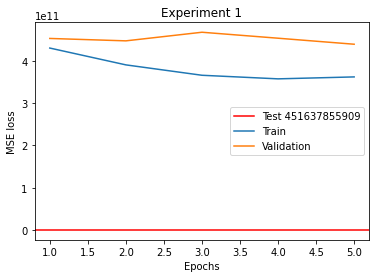

In [21]:
import matplotlib.pyplot as plt
plt.ylabel('MSE loss')
plt.xlabel('Epochs')
plt.title('Experiment 1')
plt.axhline(y=7668, color='r', linestyle='-', label='Test ' + str(int(test_loss)))
plt.plot(history_epochs,history_train, label='Train')
plt.plot(history_epochs,history_val, label='Validation')
plt.legend()
#plt.savefig('./experiment_plots/exp.2.1.simulated_history.png')

In [19]:
y_one_hot = make_sns_onehot(GAUSS_SIM_BATCH_NUMBER, batch_number_max)

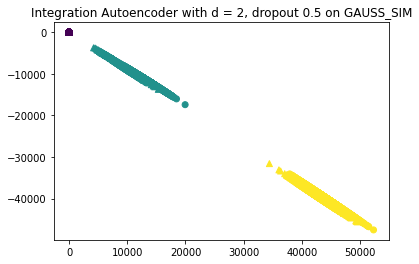

In [20]:
X_tensor = torch.tensor(GAUSS_SIM)
net.eval()
X_encoded = None
with torch.no_grad():
    X_encoded = net.encode(X_tensor.float(), y_one_hot)
X_encoded_x = X_encoded[:,0].numpy()
X_encoded_y = X_encoded[:,1].numpy()
plt.title('Integration Autoencoder with d = 2, dropout 0.5 on GAUSS_SIM')
plt.scatter(X_encoded_x[:7000], X_encoded_y[:7000], c=GAUSS_SIM_LABELS[:7000], marker='o')
plt.scatter(X_encoded_x[7000:], X_encoded_y[7000:], c=GAUSS_SIM_LABELS[7000:], marker='^')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/exp.2.2.gauss_sim_d2_dropout0.5.png')